### Required Libraries

In [ ]:
# !pip install deepface
from deepface import DeepFace
from deepface.commons import distance

In [121]:
import time
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import faiss

### Common Configurations

In [10]:
model_name = "Facenet"
detector_backend = "mtcnn"
distance_metric = "euclidean"

### Face verification

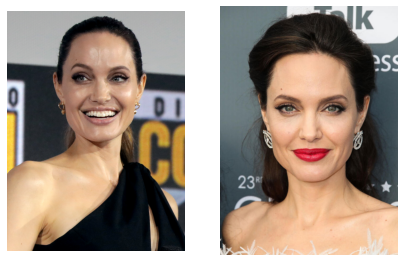

In [38]:
img1_path = "deepface/tests/dataset/img1.jpg"
img2_path = "deepface/tests/dataset/img6.jpg"
# img2_path = "deepface/tests/dataset/img3.jpg"

img1 = cv2.imread(img1_path)
img2 = cv2.imread(img2_path)

ax = plt.figure(figsize=(7, 7))

ax.add_subplot(1, 2, 1)
plt.imshow(img1[:,:,::-1])
plt.axis("off")

ax.add_subplot(1, 2, 2)
plt.imshow(img2[:,:,::-1])
plt.axis("off")

plt.show()

In [9]:
DeepFace.verify(
    img1_path=img1_path, 
    img2_path=img2_path,
    model_name=model_name,
    detector_backend = detector_backend,
    distance_metric=distance_metric
)

{'verified': True,
 'distance': 7.035519906094871,
 'threshold': 10,
 'model': 'Facenet',
 'detector_backend': 'mtcnn',
 'similarity_metric': 'euclidean',
 'facial_areas': {'img1': {'x': 412, 'y': 161, 'w': 593, 'h': 853},
  'img2': {'x': 182, 'y': 180, 'w': 394, 'h': 562}},
 'time': 5.52}

Time complexity of face verification task is O(1) in big O notation

# Background of Face verification

In [15]:
face_idx = 0 # get first face in the image

embedding_1 = DeepFace.represent(
    img_path=img1_path, 
    model_name=model_name,
    detector_backend=detector_backend
)[face_idx]

embedding_2 = DeepFace.represent(
    img_path=img2_path, 
    model_name=model_name,
    detector_backend=detector_backend
)[face_idx]

In [17]:
embedding_1.keys()

dict_keys(['embedding', 'facial_area', 'face_confidence'])

In [30]:
print("embbeding has # dimensions:")
print(len(embedding_1["embedding"]))

embbeding has # dimensions:
128


In [21]:
barcode_1 = []; barcode_2 = []
for i in range(0, 200):
    barcode_1.append(embedding_1["embedding"])
    barcode_2.append(embedding_2["embedding"])

barcode_1 = np.array(barcode_1)
barcode_2 = np.array(barcode_2)

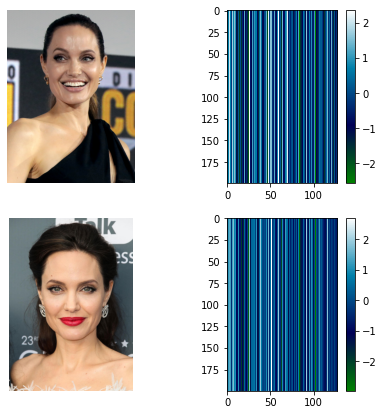

In [31]:
fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(2,2,1)
plt.imshow(img1[:,:,::-1])
plt.axis('off')

ax2 = fig.add_subplot(2,2,2)
im = plt.imshow(barcode_1, interpolation='nearest', cmap=plt.cm.ocean)
plt.colorbar()

ax3 = fig.add_subplot(2,2,3)
plt.imshow(img2[:,:,::-1])
plt.axis('off')

ax4 = fig.add_subplot(2,2,4)
im = plt.imshow(barcode_2, interpolation='nearest', cmap=plt.cm.ocean)
plt.colorbar()

plt.show()

In [35]:
similarity = distance.findEuclideanDistance(
    source_representation=embedding_1["embedding"],
    test_representation=embedding_2["embedding"]
)

print(similarity)

7.035519906094871


In [36]:
threshold = distance.findThreshold(
    model_name = model_name, 
    distance_metric = distance_metric
)

print(threshold)

10


In [37]:
if similarity < threshold:
    print("same person")
else:
    print("different persons")

same person


### Face verification to face recognition

I already found the embeddings of deepface unit test items

In [40]:
with open(f"deepface/tests/dataset/representations_{model_name}.pkl", "rb") as f:
    representations = pickle.load(f)

In [45]:
df = pd.DataFrame(representations, columns = ["img_name", "embedding"])

In [48]:
df.head()

,img_name,embedding
0,dataset/img22.jpg,"[1.5703959465026855, 0.9783668518066406, -0.73..."
1,dataset/img36.jpg,"[0.940792441368103, -0.27995753288269043, -0.2..."
2,dataset/img37.jpg,"[1.6625159978866577, 1.4390840530395508, -0.19..."
3,dataset/img23.jpg,"[1.740931749343872, 2.3877077102661133, -0.848..."
4,dataset/img35.jpg,"[0.7260245084762573, 1.0484029054641724, 0.088..."


In [46]:
df.shape

(71, 2)

In [47]:
# embedding of img1.jpg
source_embedding = embedding_1["embedding"]

In [112]:
found_identities = []
found_distances = []
tic = time.time()
for index, instance in df.iterrows():
    img_name = instance["img_name"]
    target_embedding = instance["embedding"]
    
    if img_name == "dataset/"+img1_path:
        continue
        
    similarity = distance.findEuclideanDistance(
        source_embedding, 
        target_embedding
    )
    
    if similarity < threshold:
        found_identities.append(img_name)
        found_distances.append(similarity)

toc = time.time()
duration = round(toc - tic, 4)
print(f"face recognition is done in {duration} seconds for {df.shape[0]} instances")

face recognition is done in 0.0077 seconds for 71 instances


dataset/img5.jpg  with 7.8904777915954325


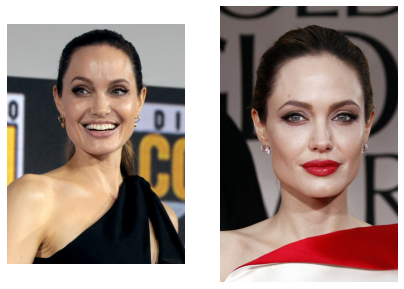

----------------
dataset/img4.jpg  with 7.296795344883553


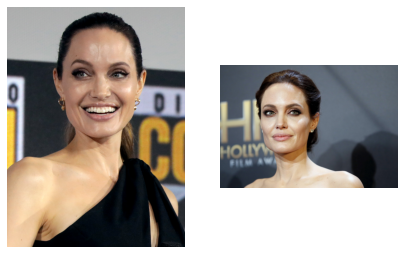

----------------
dataset/img6.jpg  with 7.035519906094871


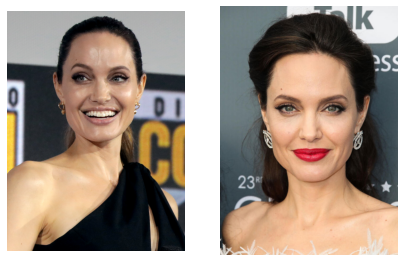

----------------
dataset/img7.jpg  with 7.00583105100339


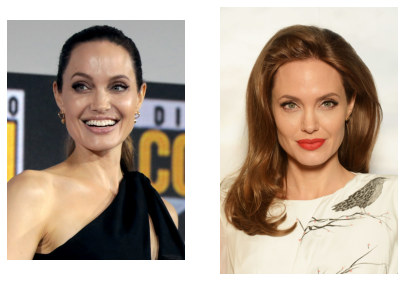

----------------
dataset/img2.jpg  with 7.568734349439781


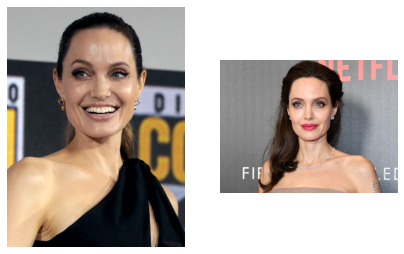

----------------
dataset/img1.jpg  with 0.0


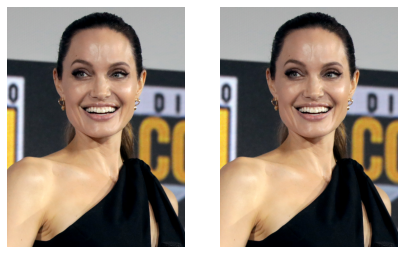

----------------
dataset/couple.jpg  with 8.77908159638332


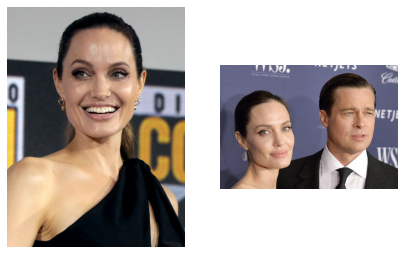

----------------
dataset/img11.jpg  with 7.510872203944662


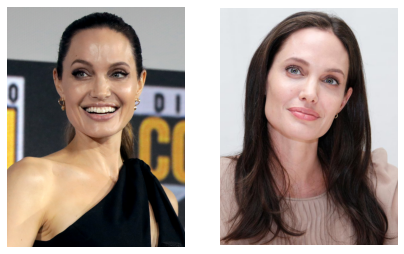

----------------
dataset/img10.jpg  with 7.567741082359515


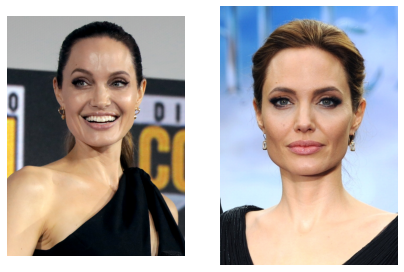

----------------


In [113]:
for index, found_identity in enumerate(found_identities):
    print(found_identity, f" with {found_distances[index]}")
    current_img = cv2.imread(f"deepface/tests/{found_identity}")
        
    fig = plt.figure(figsize=(7, 7))
        
    ax1 = fig.add_subplot(1, 2, 1)
    plt.imshow(img1[:,:,::-1])
    plt.axis("off")
        
    ax1 = fig.add_subplot(1, 2, 2)
    plt.imshow(current_img[:,:,::-1])
    plt.axis("off")
        
    plt.show()
        
    print("----------------")

# So, face recognition is easy if database is small!

It can be done in milliseconds even in serial and no demography

### What if we have a big data?

In [91]:
database_size = 1000000

In [138]:
synthetic = np.random.random((database_size - df.shape[0], 128)).astype("float32")*20 - 10

In [139]:
synthetic.max(), synthetic.min()

(10.0, -10.0)

In [140]:
print(
    synthetic.shape[0], " synthetic data created in scale of [", 
    synthetic.min(), ", ", synthetic.max(), "]"
)

999929  synthetic data created in scale of [ -10.0 ,  10.0 ]


In [141]:
representations = []
for index, instance in df.iterrows():
    target_embedding = instance["embedding"]
    representations.append(target_embedding)
representations = np.array(representations, dtype="f")

In [142]:
representations = np.concatenate((representations, synthetic), axis = 0)

In [143]:
print("database size: ", representations.shape)

database size:  (1000000, 128)


# k-NN search

In [144]:
k = 5

In [145]:
tic = time.time()
distances = []
for current_embedding in representations:
    current_distance = distance.findEuclideanDistance(
        current_embedding, 
        source_embedding, #img1.jpg
    )
    distances.append(current_distance)

# distances = np.linalg.norm(representations - np.array(source_embedding), axis = 1)

k_nearests = np.argpartition(distances, k+1)[1:k+1]

toc = time.time()

knn_time = toc - tic

print(f"k-nearest neighbour performed in {knn_time} secs")

k-nearest neighbour performed in 14.916213989257812 secs


- We can speed the calculation up with numpy instead of for loops, but still not enough

dataset/img7.jpg  with 7.00583105100339


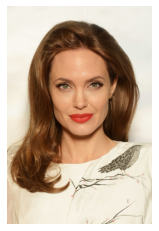

dataset/img4.jpg  with 7.296795344883553


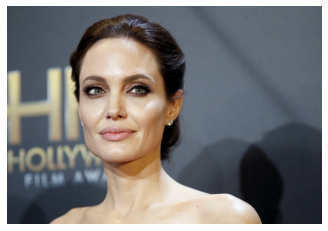

dataset/img11.jpg  with 7.510872203944662


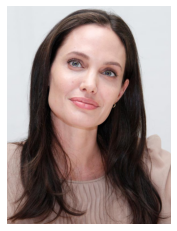

dataset/img10.jpg  with 7.567741082359515


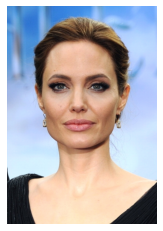

In [147]:
for k_nearest in k_nearests:
    img_name = df.iloc[k_nearest]["img_name"]
    similarity = distances[k_nearest]
    if similarity == 0:
        continue
        
    print(img_name, f" with {similarity}")
    img = cv2.imread(f"deepface/tests/{img_name}")
    plt.imshow(img[:, :, ::-1])
    plt.axis("off")
    plt.show()

# Launch Approximate Nearest Neighbour

Jump to A-NN notebook

# A-NN Instead of K-NN

- [Spotify Annoy](https://sefiks.com/2020/09/16/large-scale-face-recognition-with-spotify-annoy/)
- [Facebook Faiss](https://sefiks.com/2020/09/17/large-scale-face-recognition-with-facebook-faiss/)
- [NMSLIB](https://sefiks.com/2020/09/19/large-scale-face-recognition-with-nmslib/)
- [ElasticSearch](https://sefiks.com/2020/11/27/large-scale-face-recognition-with-elasticsearch/)

In [186]:
# euclidean l2 not euclidean
index = faiss.IndexFlatL2(128)

In [181]:
# this is going to be done once

tic = time.time()
index.add(representations)
toc = time.time()

print(f"{representations.shape[0]} embeddings added into faiss index in {toc-tic} secs")

1000000 embeddings added into faiss index in 0.2689931392669678 secs


In [182]:
source_embedding_np = np.array(source_embedding, dtype = "f")
source_embedding_np = np.expand_dims(source_embedding_np, axis = 0)
print(source_embedding_np.shape)

(1, 128)


In [183]:
tic = time.time()
distances, neighbours = index.search(source_embedding_np, k)
toc = time.time()

ann_time = toc - tic

print(f"a-nn search performed in {ann_time} secs")

a-nn search performed in 0.03720593452453613 secs


dataset/img7.jpg with 49.081668853759766


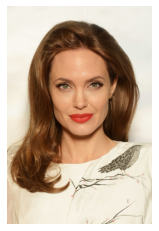

-------------
dataset/img6.jpg with 49.49854278564453


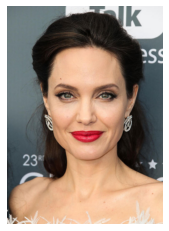

-------------
dataset/img4.jpg with 53.24322509765625


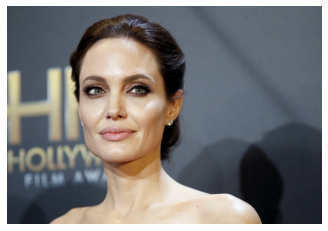

-------------
dataset/img11.jpg with 56.41320037841797


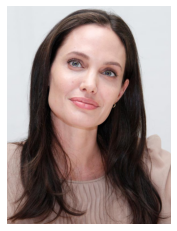

-------------


In [188]:
similarities = distances[0].tolist()

for idx, neighbour in enumerate(neighbours[0]):
    img_name = df.iloc[neighbour]["img_name"]
    similarity = similarities[idx]
    # current_embedding = df.iloc[neighbour]["embedding"]
    # similarity = distance.findEuclideanDistance(current_embedding, source_embedding)
    if similarity == 0:
        continue
            
    print(f"{img_name} with {similarity}")
    img = cv2.imread(f"deepface/tests/{img_name}")
    plt.imshow(img[:,:,::-1])
    plt.axis("off")
    plt.show()
    print("-------------")

In [179]:
improvement = round(knn_time / ann_time, 2)
print(f"a-nn is {improvement} times faster than k-nn on {representations.shape[0]} database")

a-nn is 404.84 times faster than k-nn on 1000000 database
